# Challenge Unsupervised Learning 

Mitch Shiles 

This challenge continues an investigation into stanfords Deep Solar data set. The data set compiles solar installation data from the contiguous 48 states. The data was collected through analysis of satalite images. Additionally, the data set compiles information from the American Community Survey, and from North Carolina State University's DESIRE website on government incentives. 
    One of the reoccuring problems when analyzing this data set is determining measures of success for deployment of solar panels in certain geographic and demographic regions. For example how do you reconcile the differences in solar deployment between urban, suburban, and rural areas.  In urban areas the rate of solar adoption per person is quite low, yet these areas often have a high rate of solar panels per unit of geographic area.  The opposite is often true for rural areas, while suburban areas are often a convoluted mixture. The type of area is also likely to influence how solar panels will be purchased. Selling in densely populated urban areas can be problematic due complications around building ownership. 
    Another complex problem aspect of the solar market are the effect of governmnet programs such as tax incentives and rebates on solar items. often states deploy a wide array of legislation to promote solar installations with some laws being more effective and numerous than others. 
    
   Ultimately the goal of this notebook is to identify clusters that can help define the solar panel market. In the notebook below the numerical features will be normalized and run through several clustering algorithms. The clusters will then be evaluated with silhouette scores and by checking for consistency in the clusters formed in PCA and UMAP projections.  Once an appropriate clustering method is found the data set will be lableled with clusters. The clusters will then be explored using Basemaps and through random forrest selection to find relevant variables. 

In [69]:
#import the libraries needed for the challenge 

#import pandas and numpy 
import numpy as np
import pandas as pd

#import machine learning libraries 
import sklearn
from sklearn.datasets import fetch_openml
from sklearn import datasets, metrics


    #clustering algorithms
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

    # data preperation 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

    #dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

    #Clustering 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage


#import graphing libraries 
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.basemap import Basemap

import seaborn as sns

#import time series and warninng librarie s
import time
import warnings

pd.plotting.register_matplotlib_converters()

#set the display opptions for pandas 
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#ignore all warnings 
warnings.filterwarnings("ignore")

In [70]:
#import the Deep solar CSV into a dataframe 
# http://web.stanford.edu/group/deepsolar/home
Deep_Solar_df = pd.read_csv('/Users/robertshiles/CSV_files/deepsolar_tract.csv',encoding= 'latin1')
Deep_Solar_df.head()

Unnamed: 0  tile_count  solar_system_count  total_panel_area         fips  average_household_income          county  education_bachelor  education_college  education_doctoral  education_high_school_graduate  education_less_than_high_school  education_master  education_population  education_professional_school  employed  gini_index  heating_fuel_coal_coke  heating_fuel_electricity  heating_fuel_fuel_oil_kerosene  heating_fuel_gas  heating_fuel_housing_unit_count  heating_fuel_none  heating_fuel_other  heating_fuel_solar  land_area  per_capita_income  population  population_density  poverty_family_below_poverty_level  poverty_family_count  race_asian  race_black_africa  race_indian_alaska  race_islander  race_other  race_two_more  race_white state  total_area  unemployed  water_area  education_less_than_high_school_rate  education_high_school_graduate_rate  education_college_rate  education_bachelor_rate  education_master_rate  education_professional_school_rate  \
0           0         0.0                 0.0          0.000000  27145011200              70352.789869  Stearns County                 569               1690                  13                            1757                              336               157                  4548                             26      3569      0.3490                     200                       448                              98              1720                             2527                 10                  51                   0  147.73120            26999.0        6577            44.52005                                  85                  1911          28                 19                  16              0           6             88        6420    mn   154.37190         136    6.640769                              0.073879                             0.386324                0.371592                 0.125110               0.034521                            0.005717   
1           1        25.0                21.0       1133.436461  27145011301              61727.085202  Stearns County                 674               1434                 108                             767                              222               285                  3533                             43      4795      0.4074                      20                       379                              17              1799                             2230                  0                  15                   0   16.61679            20951.0        8020           482.64430                                 189                  1359         188                205                  23              0          67            132        7405    mn    16.69968         233    0.082887                              0.062836                             0.217096                0.405887                 0.190773               0.080668                            0.012171   
2           2         3.0                 3.0         64.505776  27145011302              71496.886583  Stearns County                 854               1459                  31                            1541                              289               276                  4480                             30      3550      0.3926                      69                       440                              45              2098                             2698                 29                  17                   0   37.44482            28021.0        6971           186.16730                                 134                  1961           0                  0                   2              0          18             12        6939    mn    39.33050         151    1.885683                              0.064509                             0.343973                0.325670                 0.190625               0.061607                            0.006696   
3           3         0.0                 0.0          0.000000  27145011304   

## Missing Data
when examining the nulls it appears that voting percentages are missing the largest amount of data. when further explored these account for the MNAR data for the missing states. 
it appears that a large amount are also missing geographic data however this data appears to be missing at random, and might be filled once clusters are formulated 

In [71]:
# Create a new datafram that counts missing values

nulls = Deep_Solar_df.isin([np.nan]).sum()
zeros = Deep_Solar_df.isin([0]).sum()
tots = Deep_Solar_df.count()
state_zeros = Deep_Solar_df.groupby('state', axis = 0).agg(lambda x: x.eq(0).sum())  


state_nulls = Deep_Solar_df.groupby('state', axis = 0).agg(lambda x: x.isnull().sum())  

state_sums = Deep_Solar_df.groupby('state', axis = 0).sum()  

state_null_fractions = state_nulls/state_sums

null_df =  pd.DataFrame()
null_df['tot_frac'] = nulls/tots
null_df['nulls'] = nulls
null_df['zeros'] = zeros

#transpose dataframe 
null_df = null_df.T
#add null and zero counts for 
#null_df = null_df.append(state_null_fractions)
#null_df['sum_of_nulls'] = null_df.sum(axis=1)
null_df.insert(1,'sum_of_nulls',state_nulls.sum(axis=1))

#null_df = null_df.append(state_zeros)

# sort dataframe to find groups with a high number of zeros or missing values
#null_df = null_df.sort_values(by=['sum_of_nulls'],ascending=False )

#sort dataframe
null_df = null_df.sort_values(by='nulls', axis=1, ascending=False, inplace=False, kind='quicksort', na_position='last')

#pd.set_option(optname, val)
null_df.head(60)


voting_2012_dem_percentage  voting_2012_gop_percentage  cooling_design_temperature  relative_humidity          lon    elevation  heating_design_temperature  earth_temperature_amplitude   frost_days  air_temperature  daily_solar_radiation  atmospheric_pressure   wind_speed  earth_temperature  heating_degree_days  cooling_degree_days          lat  housing_unit_median_gross_rent  housing_unit_median_value  mortgage_with_rate  dropout_16_19_inschool_rate  median_household_income  average_household_income  gini_index  travel_time_average  poverty_family_below_poverty_level_rate  average_household_size  heating_fuel_gas_rate  heating_fuel_electricity_rate  household_type_family_rate  heating_fuel_fuel_oil_kerosene_rate  heating_fuel_coal_coke_rate  heating_fuel_solar_rate  heating_fuel_other_rate  heating_fuel_none_rate  occupancy_vacant_rate  occupancy_owner_rate  occupation_information_rate  occupation_transportation_rate  occupation_construction_rate  occupation_finance_rate  \
tot_frac                    0.170272                    0.170272                    0.086941           0.086941     0.086941     0.086941                    0.086941                     0.086941     0.086941         0.086941               0.086941              0.086941     0.086941           0.086941             0.086941             0.086941     0.086941                        0.028004                   0.026811             0.01591                     0.014844                  0.01337                  0.012365    0.011815             0.011815                                 0.011476                0.011265               0.010743                       0.010743                    0.010743                             0.010743                     0.010743                 0.010743                 0.010743                0.010743               0.010391              0.010391                     0.009899                        0.009899                      0.009899                 0.009899   
nulls                   10554.000000                10554.000000                 5802.000000        5802.000000  5802.000000  5802.000000                 5802.000000                  5802.000000  5802.000000      5802.000000            5802.000000           5802.000000  5802.000000        5802.000000          5802.000000          5802.000000  5802.000000                     1976.000000                1894.000000          1136.00000                  1061.000000                957.00000                886.000000  847.000000           847.000000                               823.000000              808.000000             771.000000                     771.000000                  771.000000                           771.000000                   771.000000               771.000000               771.000000              771.000000             746.000000            746.000000                   711.000000                      711.000000                    711.000000               711.000000   
zeros                       0.000000                    0.000000                    0.000000           0.000000     0.000000     0.000000                  483.000000                     0.000000  7607.000000         0.000000               0.000000              0.000000     0.000000           0.000000             0.000000             0.000000     0.000000                        0.000000                   0.000000           203.00000                    42.000000                  0.00000                  0.000000    0.000000             0.000000                              1910.000000                0.000000             335.000000                     262.000000                   52.000000                         38651.000000                 37539.000000             67000.000000             47476.000000            39840.000000            1466.000000            390.000000                  9082.000000                     1493.000000                   1573.000000              1108.000000   

         

In [72]:
#drop columns with abnormally high number of null values 
Deep_Solar_df = Deep_Solar_df.drop(['voting_2012_gop_percentage',
                                    'voting_2012_dem_percentage',
                                   ], axis=1)

In [73]:
# create and empty dataframe to store variables 
X = pd.DataFrame()

# add the variables and drop the null values 
X = Deep_Solar_df[[
'population_density',
'avg_electricity_retail_rate',
'rebate',
'sales_tax',
'feedin_tariff',
'net_metering',
'incentive_nonresidential_state_level',
'incentive_residential_state_level',
'incentive_count_nonresidential',
'incentive_count_residential',
'total_panel_area_nonresidential',
'total_panel_area_residential',
'solar_system_count_nonresidential',
'solar_system_count_residential',
'tile_count_nonresidential',
'tile_count_residential',
'electricity_price_residential',
'electricity_price_industrial',
'electricity_price_commercial',
'daily_solar_radiation',
#to be included in y
'solar_system_count',
'solar_panel_area_per_capita',
'solar_panel_area_divided_by_area'
]].dropna(axis = 0)

y=pd.DataFrame()

# create a dataframe to store values of interest
# note y will not be used as labels or groundtruths for the clustering it will only be used for later analysis 
y= X[['solar_system_count',
'solar_panel_area_per_capita',
'solar_panel_area_divided_by_area']]

# drop the variables not to be used for clustering  
X = X.drop(columns = ['solar_system_count',
'solar_panel_area_per_capita',
'solar_panel_area_divided_by_area'])

y.solar_system_count

X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 66457 entries, 0 to 72536
Data columns (total 20 columns):
population_density                      66457 non-null float64
avg_electricity_retail_rate             66457 non-null float64
rebate                                  66457 non-null int64
sales_tax                               66457 non-null int64
feedin_tariff                           66457 non-null int64
net_metering                            66457 non-null int64
incentive_nonresidential_state_level    66457 non-null int64
incentive_residential_state_level       66457 non-null int64
incentive_count_nonresidential          66457 non-null int64
incentive_count_residential             66457 non-null int64
total_panel_area_nonresidential         66457 non-null float64
total_panel_area_residential            66457 non-null float64
solar_system_count_nonresidential       66457 non-null float64
solar_system_count_residential          66457 non-null float64
tile_count_nonresidential

In [74]:
#np.isnan(mat.any()) #and gets False
#np.isfinite(mat.all()) #and gets True
#is obviously wrong. Right would be:

#np.any(np.isnan(X))

X = X.round(3)
print(np.all(np.isfinite(X)),np.any(np.isnan(X)))

True False


### Create A Heat Map of Variable Correlations 

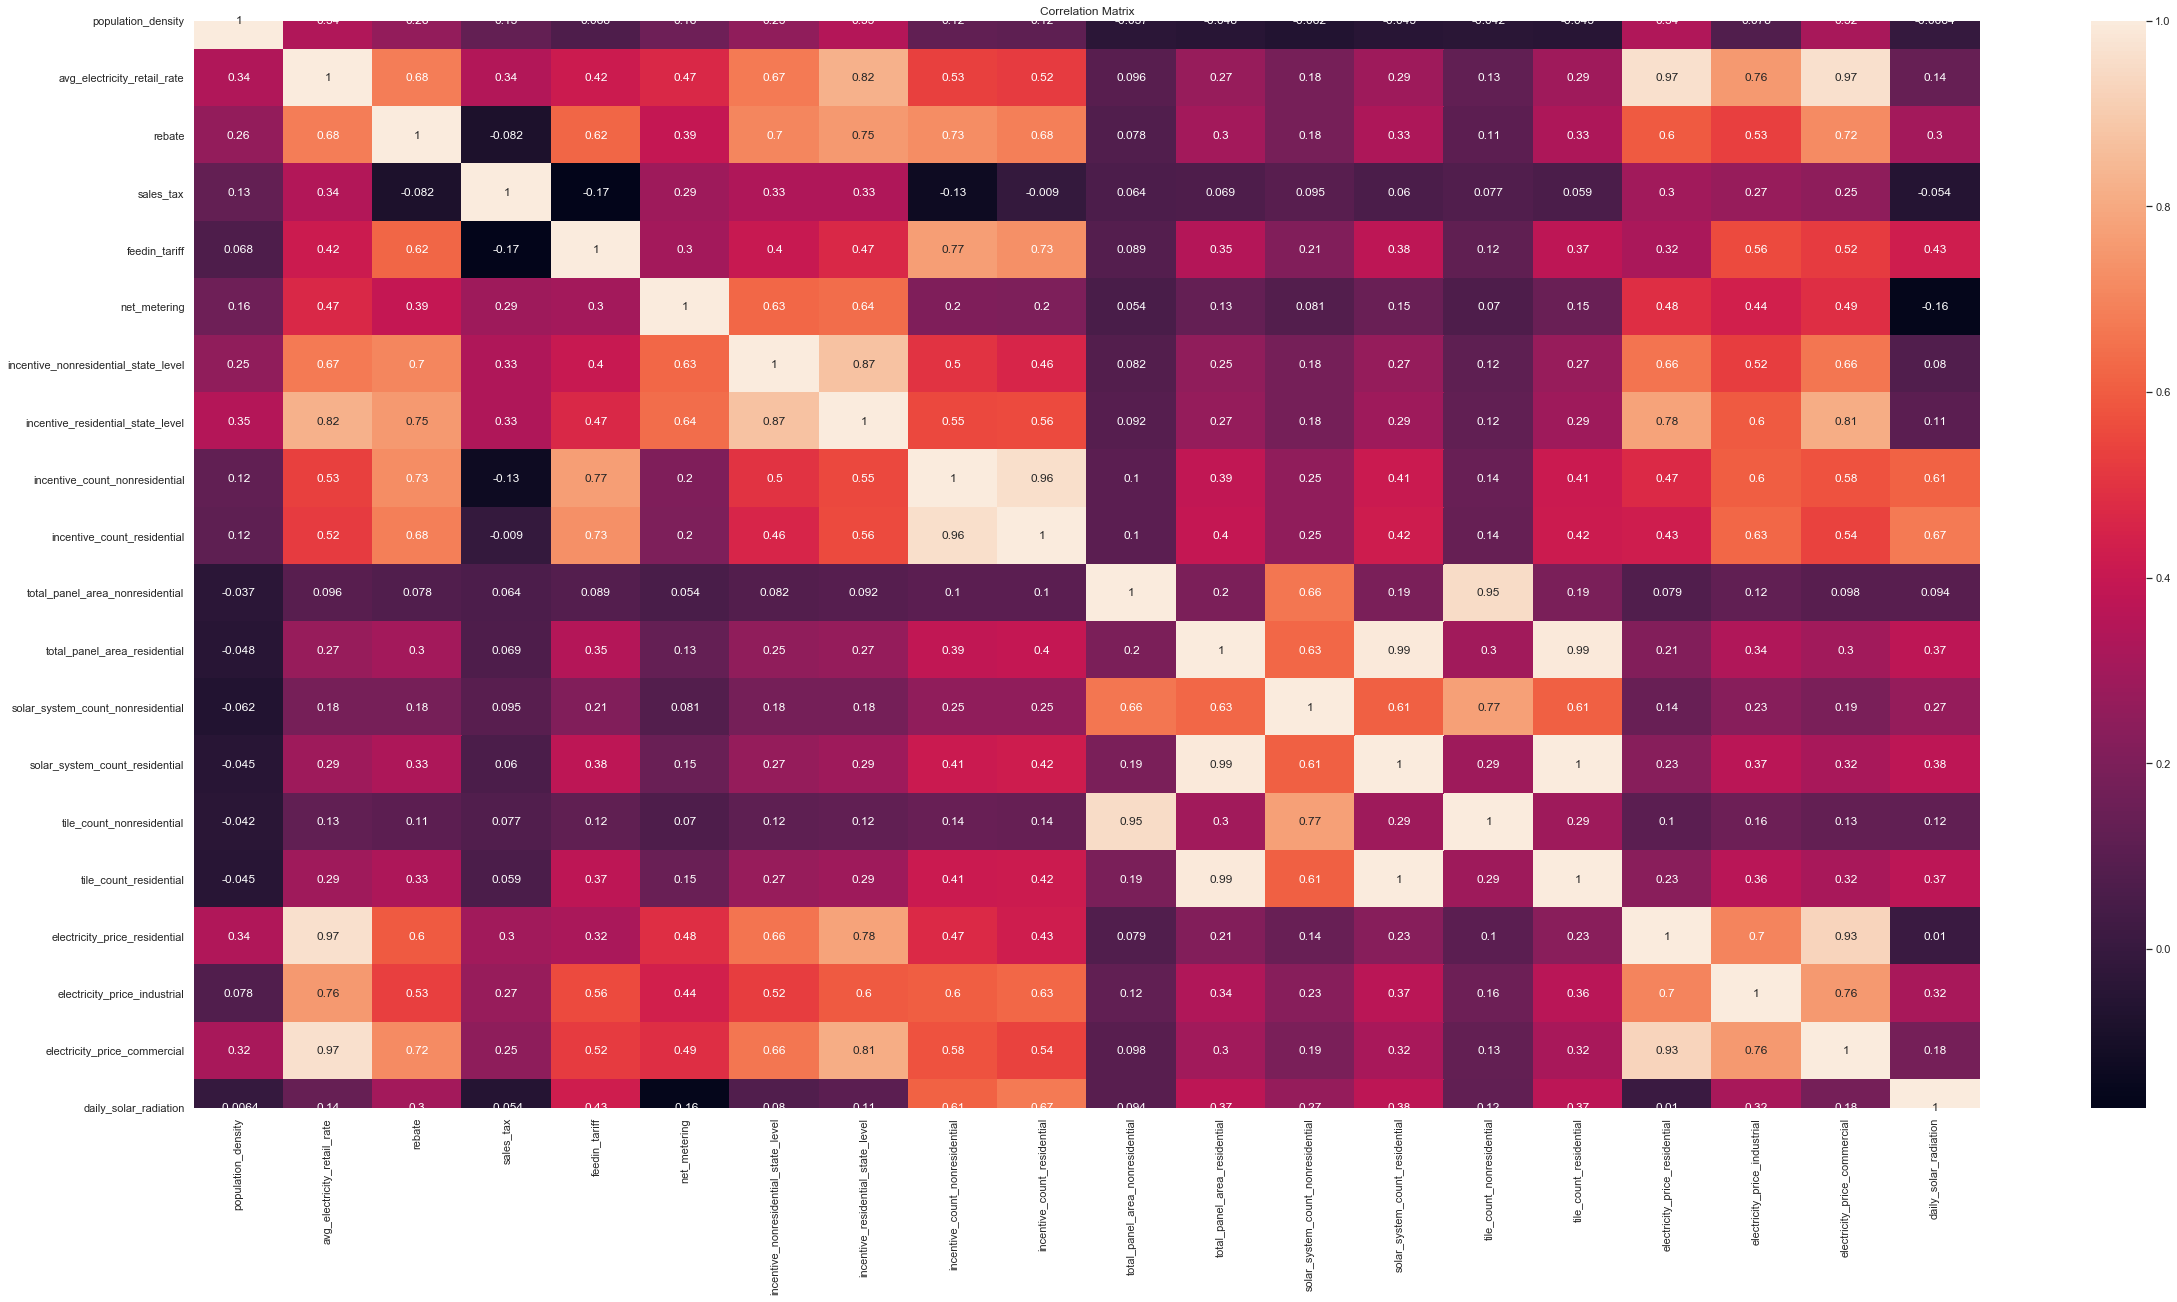

In [75]:
plt.figure(figsize=(40,20))
sns.set(rc={ 'figure.facecolor':'tab:gray'})
heat_corr = X.corr()
sns.heatmap(heat_corr, annot=True) 
plt.title("Correlation Matrix")
plt.show()

In [76]:
columns = X.columns
print(len(columns))

20


<Figure size 432x288 with 0 Axes>

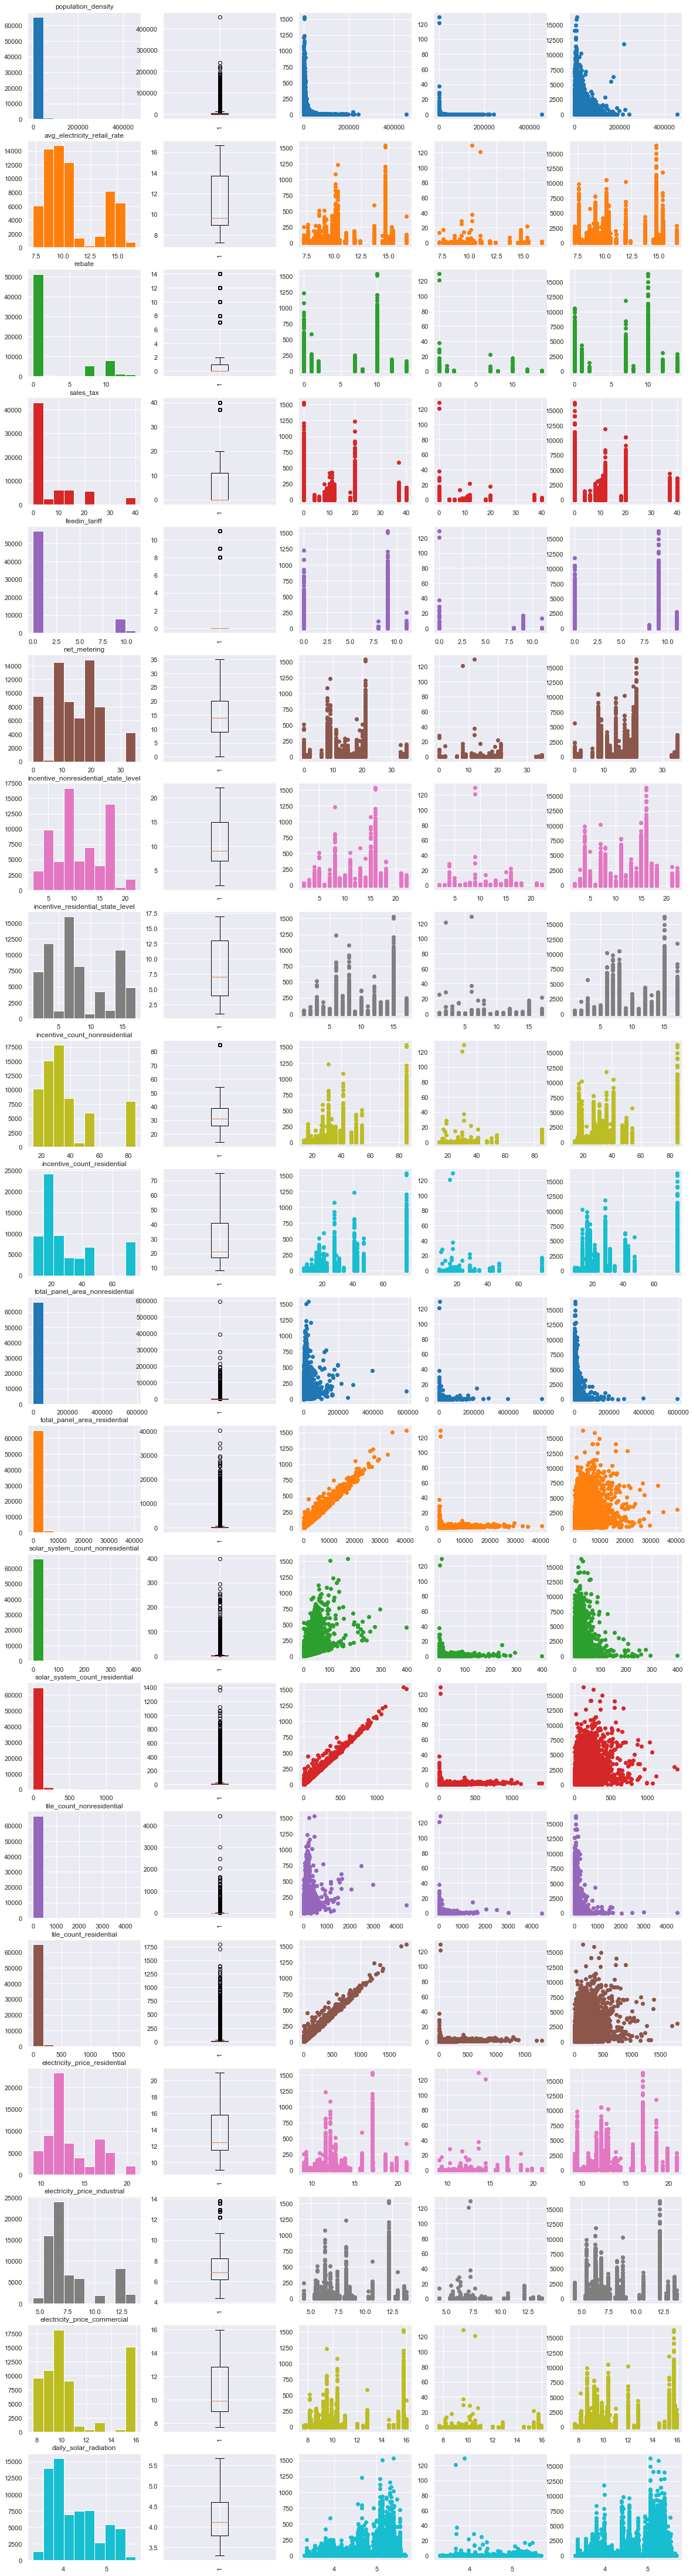

In [77]:
cont_vars = X.columns

plt.tight_layout()
sns.set(rc={ 'figure.facecolor':'white'})

plt.figure(figsize=(20,80))
colorlist = ['tab:blue','tab:orange','tab:green','tab:red',
             'tab:purple','tab:brown','tab:pink',
             'tab:grey','tab:olive','tab:cyan']



p=0
n=0
for i, var in enumerate (cont_vars,1):

    p=i*5
    c = colorlist[n]
    if n > len(colorlist)-2:
        n=0
    else:
        n+=1
        
    plt.subplot(len(cont_vars),5,p-4)
    plt.hist(X[var],color = c)
    plt.title(var)
   
    plt.subplot(len(cont_vars),5,p-3)
    plt.boxplot(X[var])
    plt.xticks(rotation='vertical')
    
    plt.subplot(len(cont_vars),5,p-2)
    plt.scatter(X[var],y = y['solar_system_count'], color = c)
    
    plt.subplot(len(cont_vars),5,p-1)
    plt.scatter(X[var],y = y['solar_panel_area_per_capita'], color = c)
    
    plt.subplot(len(cont_vars),5,p)
    plt.scatter(X[var],y = y['solar_panel_area_divided_by_area'], color = c)
    
plt.show()    


### Normalize the features


In [78]:
#np.where(X.values >= np.finfo(np.float64).max)

# Normalize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#y_std = scaler.fit_transform(y)


## Dimesnionality reduction 
the datased contains aproximatly 169 varriables in order to visualize clusters in two dimensional plots the dimensions will be reduced using PCA TSNE and UMAP. In addition these reduced dimensions may be used in the clustering algorithms themselves when the original veriables prove to be to cumbersom and computantionaly expensive. 

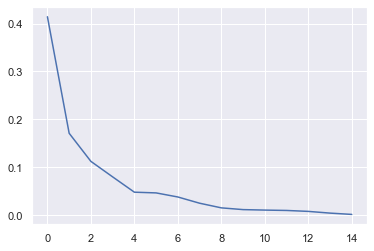

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.41421104 0.17101509 0.11234768 0.08001015 0.04806152 0.04656535
 0.03803696 0.02505    0.01535244 0.01170394 0.0106962  0.00993873
 0.00798693 0.00438712 0.00166772]


 to retain 58.52% of total variance  2 components are required
 to retain 77.76% of total variance 4 components required
 to retain 82.56% of total variance 5 components required
 to retain 91.02% of total variance 7 components required
0.9970308764218154


In [79]:
# Dimensionality reduction 
# conduct principle compenent analysis on the data and examine the explained variance of the components

sklearn_pca = PCA(n_components=15)
Y_sklearn = sklearn_pca.fit_transform(X)

pca = sklearn_pca.fit_transform(X_std)

plt.plot(sklearn_pca.explained_variance_ratio_)

plt.show()

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

explained_variance = []
explained_variance = sklearn_pca.explained_variance_ratio_

total_variace = 0
total_variace = 0
components = 0
num_prints = 0
print('\n')
for v in explained_variance:
    total_variace+=v
    components +=1
    
    if total_variace>=0.5 and total_variace<0.7 and num_prints < 1 :
        print(" to retain {}% of total variance  {} components are required".format(round(100*total_variace,2),components))
        num_prints+=1
        
    if total_variace>=0.7 and total_variace<0.8 and num_prints < 2 :
        print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
        num_prints+=1
        
    elif total_variace>=0.8 and total_variace<0.9 and num_prints < 3 :
        print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
        num_prints+=1
        
    elif total_variace>=0.9 and num_prints < 4  :
        print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
        num_prints+=1
        
    else:
        None
        
print(sum(explained_variance))


In [80]:
# We just want the first two principal components
pca = PCA(n_components=6)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(X_std)

In [81]:
# Dimensionality reduction 
#T-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

#hyper parameters = n_components=2, verbose=1, perplexity=20, n_iter=300 try 30 iterations 


print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 66457 samples in 1.798s...
[t-SNE] Computed neighbors for 66457 samples in 9.692s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66457
[t-SNE] Computed conditional probabilities for sample 2000 / 66457
[t-SNE] Computed conditional probabilities for sample 3000 / 66457
[t-SNE] Computed conditional probabilities for sample 4000 / 66457
[t-SNE] Computed conditional probabilities for sample 5000 / 66457
[t-SNE] Computed conditional probabilities for sample 6000 / 66457
[t-SNE] Computed conditional probabilities for sample 7000 / 66457
[t-SNE] Computed conditional probabilities for sample 8000 / 66457
[t-SNE] Computed conditional probabilities for sample 9000 / 66457
[t-SNE] Computed conditional probabilities for sample 10000 / 66457
[t-SNE] Computed conditional probabilities for sample 11000 / 66457
[t-SNE] Computed conditional probabilities for sample 12000 / 66457
[t-SNE] Computed conditional probabilities for sam

In [82]:
# Dimensionality reduction 
#UMAP
# try setting min distance to 0.1 or 0.15
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=30,
                      min_dist=0.1,
                      metric='correlation',
                        n_components=2,
                        random_state=42
                        ).fit_transform(X_std)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 131.9169681072235 seconds


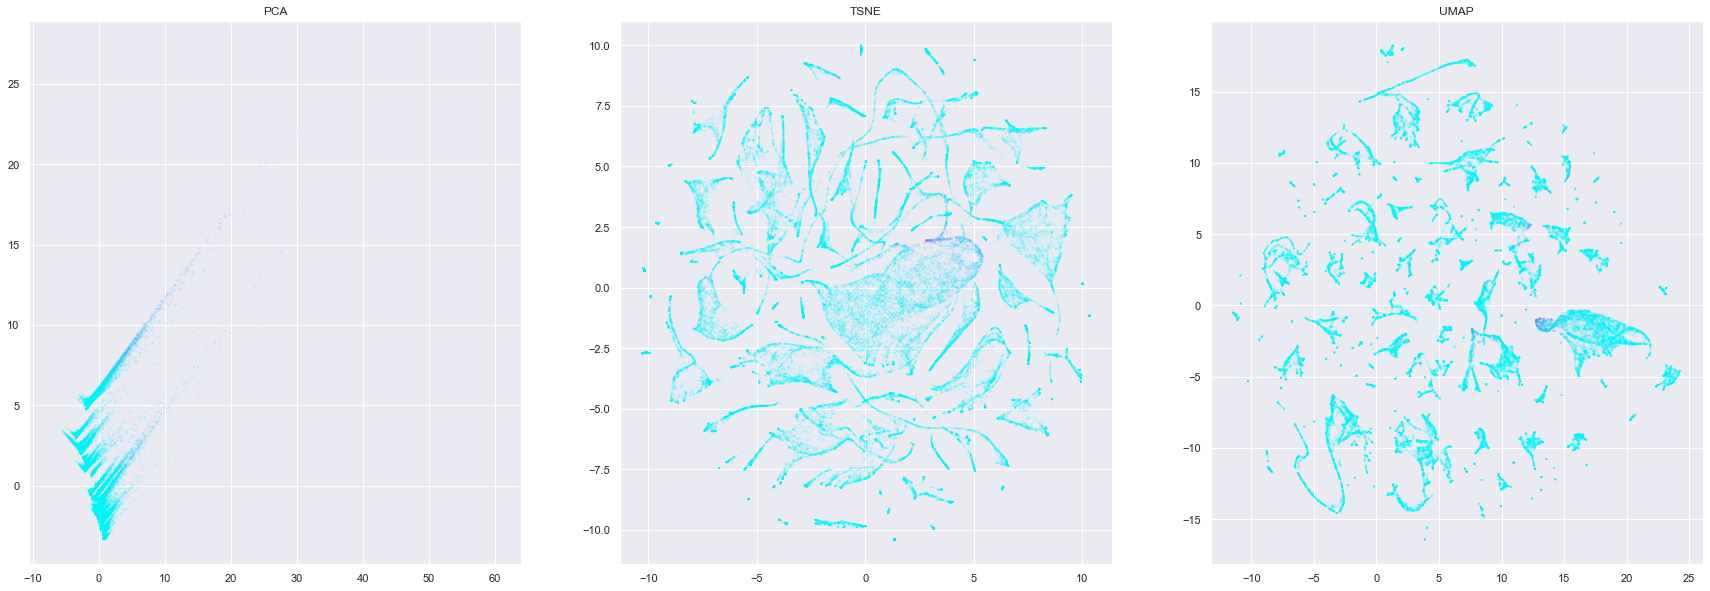

In [83]:
#plot the first two results of each reduction technique
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.title('PCA')

plt.scatter(pca_components[:, 1],  pca_components[:, 0],
            c=y.solar_system_count
            , s=1, alpha = 0.1,  cmap='cool')
plt.subplot(1,3,2)
plt.title('TSNE')

plt.scatter(tsne_results[:, 0],  tsne_results[:, 1],
            c=y.solar_system_count,
            s=1, alpha = 0.1,  cmap='cool')

plt.subplot(1,3,3)
plt.title('UMAP')
plt.scatter(umap_results[:, 0],  umap_results[:, 1],
            c=y.solar_system_count
            , s=1,alpha = 0.1,   cmap='cool')

## Split Data


In [84]:

# Split the data into two equally-sized samples. First we break it in half:
X_half1, X_half2, pca_components1, pca_components2,umap_results1,umap_results2 = train_test_split(
    X_std,
    pca_components,
    umap_results,
    test_size=0.5,
    random_state=13579)

In [85]:
## to keep track of scores silhouet scores will be stored in an array 
sil_scores = []


In [86]:
# define a function to print a list of all the cluster labels

def unique(list1): 
    # intilize a null list 
    unique_list = [] 
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    unique_list.sort()
    for x in unique_list: 
        print (x) 

## Clustering with K means 
when examining the dimensional reductions it appears that there are some clusters hiding in the data. 

In [19]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_std)
    Sum_of_squared_distances.append(km.inertia_)

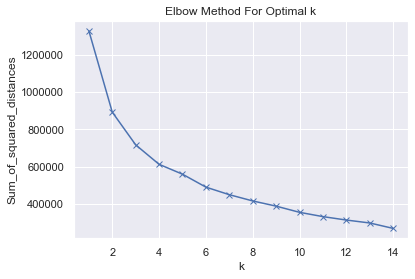

In [20]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [87]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=4, random_state=123)


In [88]:
# Fit model
%timeit kmeans_cluster.fit(X_half1)
y_pred_half1 = kmeans_cluster.predict(X_half1)

643 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
# Fit model
%timeit kmeans_cluster.fit(X_half2)
y_pred_half2 = kmeans_cluster.predict(X_half2)

538 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


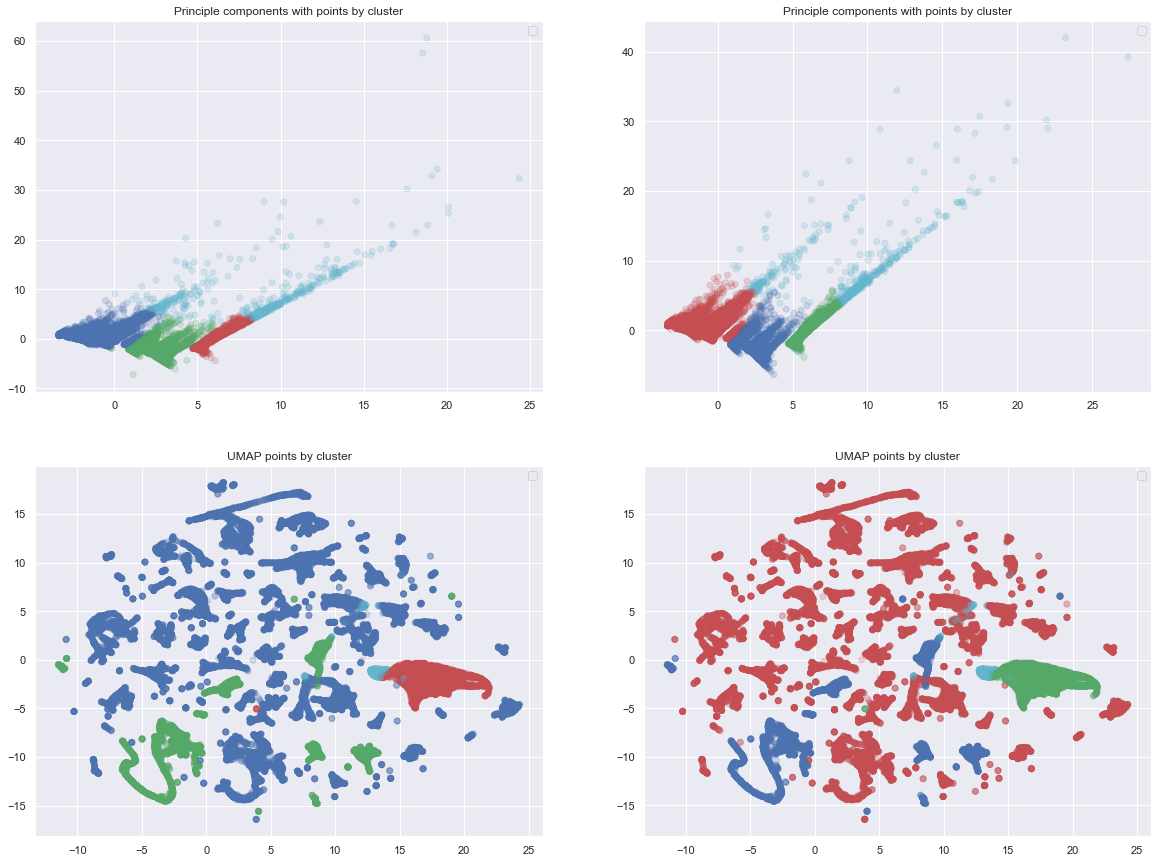

In [90]:
plt.figure(figsize=(20,15))

colours = ['r','b','g','c','m','y','k','lime','slategray','darkviolet','darkorange',]
groups =  ['0','1','2','3','4','5','6','7','8','9']

color_1 = []
color_2 = []
groups = []
for i in range(len(y_pred_half1)):
    color_1.append(colours[y_pred_half1[i]])

for j in range(len(y_pred_half2)):
    color_2.append(colours[y_pred_half2[j]])
    
    
    
plt.subplot(2,2,1)
plt.scatter(pca_components1[:, 0],
            pca_components1[:, 1],
            c=color_1,
            alpha = 0.2
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)

plt.subplot(2,2,2)
plt.scatter(pca_components2[:, 0],
            pca_components2[:, 1],
            c=color_2,
            alpha = 0.2
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)


plt.subplot(2,2,3)
plt.scatter(umap_results1[:, 0],
            umap_results1[:, 1],
            c=color_1,
            alpha = 0.2
                )
plt.title('UMAP points by cluster')
plt.legend()


plt.subplot(2,2,4)
plt.scatter(umap_results2[:, 0],
            umap_results2[:, 1],
            c=color_2,
            alpha = 0.2
                )
plt.title('UMAP points by cluster')
plt.legend()

plt.show()

In [91]:

score1 = metrics.silhouette_score(X_half1, y_pred_half1, metric='euclidean')
score2 = metrics.silhouette_score(X_half2, y_pred_half2, metric='euclidean')

print(score1,score2)
sil_scores.append(('Kmeans','euclidean',1,score1))
sil_scores.append(('Kmeans','euclidean',2,score2))


0.48785513740346226 0.4868295688869169


In [92]:
score1 = metrics.silhouette_score(X_half1, y_pred_half1, metric='cosine')

score2 = metrics.silhouette_score(X_half2, y_pred_half2, metric='cosine')

print(score1,score2)
sil_scores.append(('Kmeans','cosine',1,score1))
sil_scores.append(('Kmeans','cosine',2,score2))



0.4603496253662968 0.4644325751413205


In [93]:

score1 = metrics.silhouette_score(X_half1, y_pred_half1, metric='manhattan')

score2 = metrics.silhouette_score(X_half2, y_pred_half2, metric='manhattan')

print(score1,score2)
sil_scores.append(('Kmeans','manhattan',1,score1))
sil_scores.append(('Kmeans','manhattan',2,score2))


0.5461877159393339 0.5445204125538906


# Agglomerative Clusters 


In [94]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=4)
#Euclidean
#linkage:
    #ward minimizes the variance of the clusters being merged.
        # best for 
    #average uses the average of the distances of each observation of the two sets.
    #complete or maximum linkage uses the maximum distances between all observations of the two sets.
    #single uses the minimum of the distances between all observations of the two sets.
#Afinity:


In [95]:
# Fit model
Agg_clusters1 = agg_cluster.fit_predict(pca_components1)


In [96]:
# Fit model
Agg_clusters2 = agg_cluster.fit_predict(pca_components2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


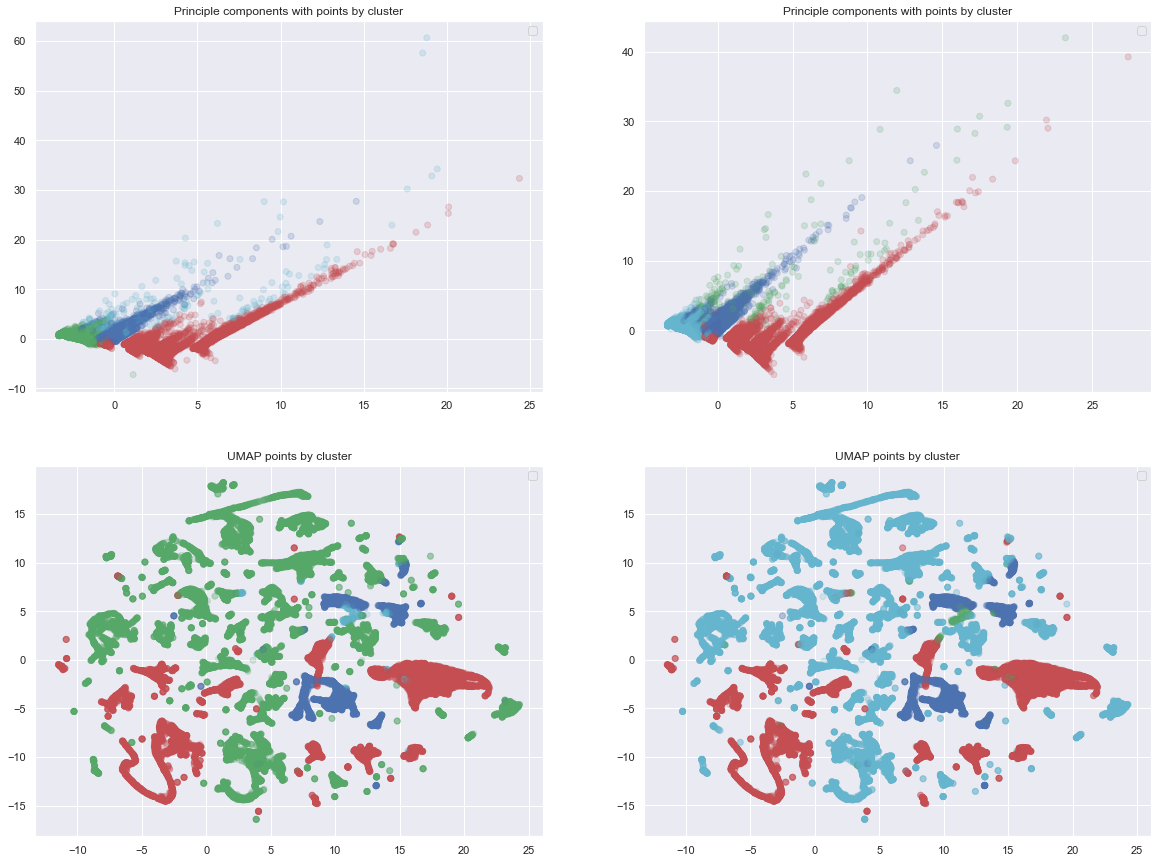

In [97]:
plt.figure(figsize=(20,15))

colours = ['r','b','g','c','m','y','k','lime','slategray','darkviolet','darkorange',]
groups =  ['0','1','2','3','4','5','6','7','8','9']

color_1 = []
color_2 = []
groups = []
for i in range(len(Agg_clusters1)):
    color_1.append(colours[Agg_clusters1[i]])

for j in range(len(Agg_clusters2)):
    color_2.append(colours[Agg_clusters2[j]])
    
    
    
plt.subplot(2,2,1)
plt.scatter(pca_components1[:, 0],
            pca_components1[:, 1],
            c=color_1,
            alpha = 0.2
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)

plt.subplot(2,2,2)
plt.scatter(pca_components2[:, 0],
            pca_components2[:, 1],
            c=color_2,
            alpha = 0.2
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)


plt.subplot(2,2,3)
plt.scatter(umap_results1[:, 0],
            umap_results1[:, 1],
            c=color_1,
            alpha = 0.2
                )
plt.title('UMAP points by cluster')
plt.legend()


plt.subplot(2,2,4)
plt.scatter(umap_results2[:, 0],
            umap_results2[:, 1],
            c=color_2,
            alpha = 0.2
                )
plt.title('UMAP points by cluster')
plt.legend()

plt.show()

In [98]:


score1 = metrics.silhouette_score(X_half1, Agg_clusters1, metric='euclidean')

score2 = metrics.silhouette_score(X_half2, Agg_clusters2, metric='euclidean')

print(score1,score2)
sil_scores.append(('Agglomerative','euclidean',1,score1))
sil_scores.append(('Agglomerative','euclidean',2,score2))


0.2736000289043354 0.2707817368621771


In [99]:


score1 = metrics.silhouette_score(X_half1, Agg_clusters1, metric='cosine')

score2 = metrics.silhouette_score(X_half2, Agg_clusters2, metric='cosine')

print(score1,score2)
sil_scores.append(('Agglomerative','cosine',1,score1))
sil_scores.append(('Agglomerative','cosine',2,score2))


0.47100486782694034 0.4659273666212992


In [100]:

score1 = metrics.silhouette_score(X_half1, Agg_clusters1, metric='manhattan')

score2 = metrics.silhouette_score(X_half2, Agg_clusters2, metric='manhattan')

print(score1,score2)
sil_scores.append(('Agglomerative','manhattan',1,score1))
sil_scores.append(('Agglomerative','manhattan',2,score2))


0.316951375980412 0.31434271223295107


# DBSCAN

In [101]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=3.5, min_samples=10)
#orig 2.75 and 80
#eps=3, min_samples=2 provides 9 clusters 2 really dense ones silscore ~0.5
#eps=.75, min_samples=5

In [102]:
# Fit model
dbscan_cluster.fit(pca_components2)
dbscan_cluster_1 = dbscan_cluster.fit_predict(pca_components1)

unique(dbscan_cluster_1)

-1
0
1
2


In [103]:
# Fit model
dbscan_cluster.fit(pca_components1)
dbscan_cluster_2 = dbscan_cluster.fit_predict(pca_components2)
unique(dbscan_cluster_2)

-1
0
1


No handles with labels found to put in legend.
No handles with labels found to put in legend.


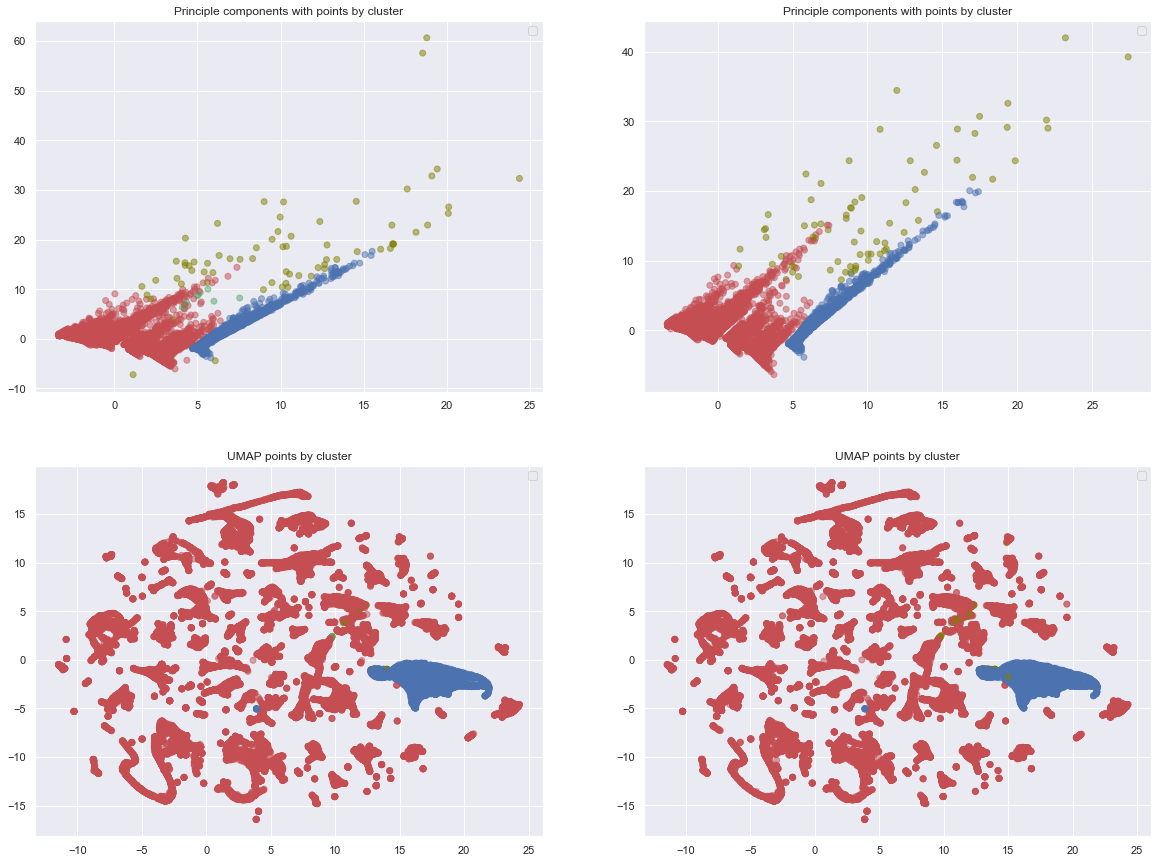

In [104]:
plt.figure(figsize=(20,15))

colours = ['r','b','g','c','m','y','k','lime','slategray','darkviolet','darkorange','olive']
groups = ['0','1','2','3','4','5']

color_1 = []
color_2 = []
groups = []
for i in range(len(dbscan_cluster_1)):
    color_1.append(colours[dbscan_cluster_1[i]])

for j in range(len(dbscan_cluster_2)):
    color_2.append(colours[dbscan_cluster_2[j]])
    
    
    
plt.subplot(2,2,1)
plt.scatter(pca_components1[:, 0],
            pca_components1[:, 1],
            c=color_1,
            #s=20*(y**2),
            alpha = 0.5
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)

plt.subplot(2,2,2)
plt.scatter(pca_components2[:, 0],
            pca_components2[:, 1],
            c=color_2,
            #s=20*(y**2),
            alpha = 0.5
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)


plt.subplot(2,2,3)
plt.scatter(umap_results1[:, 0],
            umap_results1[:, 1],
            c=color_1,
            #s=20*(y**2),
            alpha = 0.5
                )
plt.title('UMAP points by cluster')
plt.legend()


plt.subplot(2,2,4)
plt.scatter(umap_results2[:, 0],
            umap_results2[:, 1],
            c=color_2,
            #s=20*(y**2),
            alpha = 0.5
                )
plt.title('UMAP points by cluster')
plt.legend()

plt.show()


In [105]:


score1 = metrics.silhouette_score(X_half1, dbscan_cluster_1, metric='euclidean')

score2 = metrics.silhouette_score(X_half2, dbscan_cluster_2, metric='euclidean')

print(score1,score2)
sil_scores.append(('DBSCAN','euclidean',1,score1))
sil_scores.append(('DBSCAN','euclidean',2,score2))

0.5102169312634924 0.510858338817786


In [106]:


score1 = metrics.silhouette_score(X_half1, dbscan_cluster_1, metric='cosine')

score2 = metrics.silhouette_score(X_half2, dbscan_cluster_2, metric='cosine')

print(score1,score2)
sil_scores.append(('DBSCAN','cosine',1,score1))
sil_scores.append(('DBSCAN','cosine',2,score2))

0.24379794806619542 0.26984178690029154


In [107]:


score1 = metrics.silhouette_score(X_half1, dbscan_cluster_1, metric='manhattan')

score2 = metrics.silhouette_score(X_half2, dbscan_cluster_2, metric='manhattan')

print(score1,score2)
sil_scores.append(('DBSCAN','manhattan',1,score1))
sil_scores.append(('DBSCAN','manhattan',2,score2))

0.6006221736583489 0.6010140594226319


## HDBSCAN

In [108]:
import hdbscan

HDB_clusterer = hdbscan.HDBSCAN(min_cluster_size=1500, gen_min_span_tree=True)
#HDB_clusterer.fit(pca_components1)

hdbscan_cluster_2 = HDB_clusterer.fit_predict(pca_components2)


In [109]:
#HDB_clusterer.fit(pca_components2)


hdbscan_cluster_1 = HDB_clusterer.fit_predict(pca_components1)


In [110]:
unique(hdbscan_cluster_1)
unique(hdbscan_cluster_2)


-1
0
1
2
3
4
-1
0
1
2
3
4


No handles with labels found to put in legend.
No handles with labels found to put in legend.


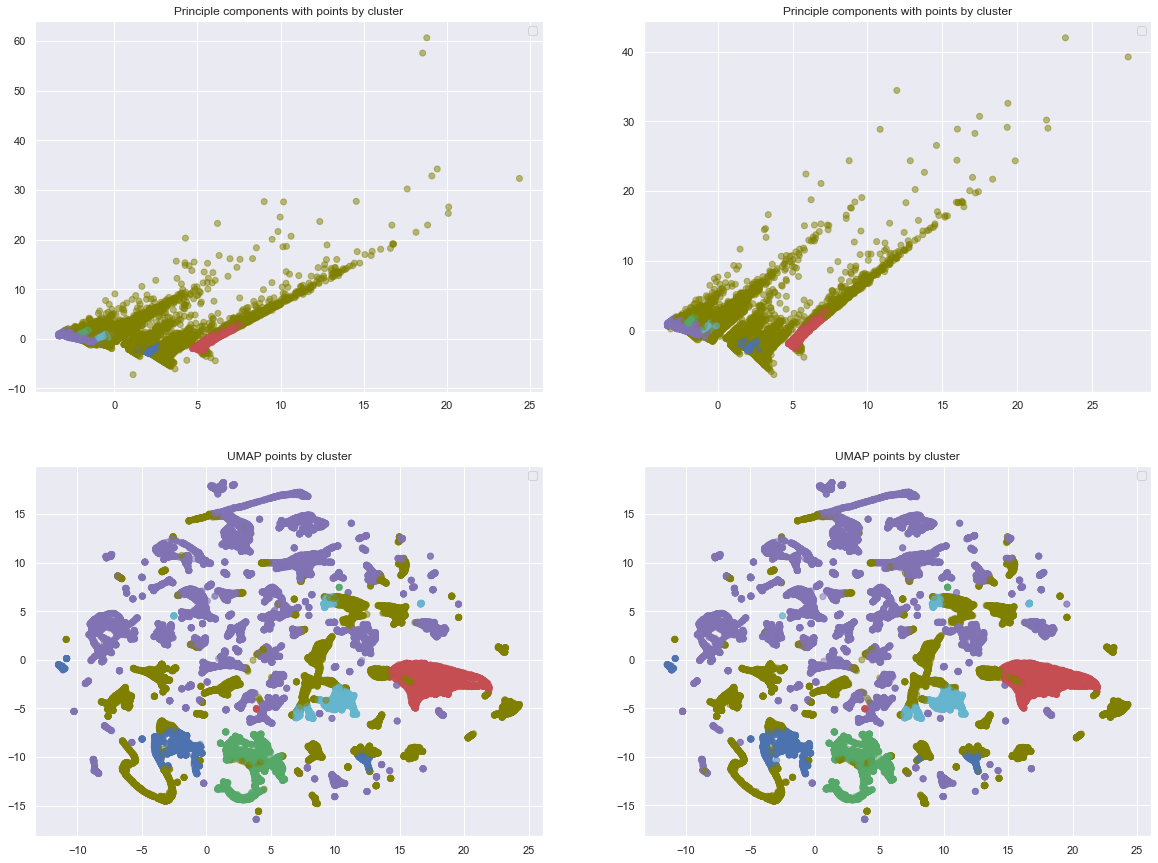

In [111]:
plt.figure(figsize=(20,15))

colours = ['r','b','g','c','m','y','k','lime','slategray','darkviolet','darkorange','olive']
groups = ['0','1','2','3','4','5']

color_1 = []
color_2 = []
groups = []
for i in range(len(dbscan_cluster_1)):
    color_1.append(colours[hdbscan_cluster_1[i]])

for j in range(len(dbscan_cluster_2)):
    color_2.append(colours[hdbscan_cluster_2[j]])
    
    
    
plt.subplot(2,2,1)
plt.scatter(pca_components1[:, 0],
            pca_components1[:, 1],
            c=color_1,
            #s=20*(y**2),
            alpha = 0.5
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)

plt.subplot(2,2,2)
plt.scatter(pca_components2[:, 0],
            pca_components2[:, 1],
            c=color_2,
            #s=20*(y**2),
            alpha = 0.5
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)


plt.subplot(2,2,3)
plt.scatter(umap_results1[:, 0],
            umap_results1[:, 1],
            c=color_1,
            #s=20*(y**2),
            alpha = 0.5
                )
plt.title('UMAP points by cluster')
plt.legend()


plt.subplot(2,2,4)
plt.scatter(umap_results2[:, 0],
            umap_results2[:, 1],
            c=color_2,
            #s=20*(y**2),
            alpha = 0.5
                )
plt.title('UMAP points by cluster')
plt.legend()

plt.show()

In [112]:

score1 = metrics.silhouette_score(X_half1, hdbscan_cluster_1, metric='euclidean')

score2 = metrics.silhouette_score(X_half2, hdbscan_cluster_2, metric='euclidean')

print(score1,score2)
sil_scores.append(('HDBSCAN','euclidean',1,score1))
sil_scores.append(('HDBSCAN','euclidean',2,score2))

0.25193172452960333 0.25322168153249514


In [113]:

score1 = metrics.silhouette_score(X_half1, hdbscan_cluster_1, metric='cosine')

score2 = metrics.silhouette_score(X_half2, hdbscan_cluster_2, metric='cosine')

print(score1,score2)
sil_scores.append(('HDBSCAN','cosine',1,score1))
sil_scores.append(('HDBSCAN','cosine',2,score2))

0.3245570571701085 0.32439432324094347


In [114]:

score1 = metrics.silhouette_score(X_half1, hdbscan_cluster_1, metric='manhattan')

score2 = metrics.silhouette_score(X_half2, hdbscan_cluster_2, metric='manhattan')

print(score1,score2)
sil_scores.append(('HDBSCAN','manhattan',1,score1))
sil_scores.append(('HDBSCAN','manhattan',2,score2))

0.24075485466004667 0.2413541386762646


# Gaussian Mixture Models 

Automatically created module for IPython interactive environment


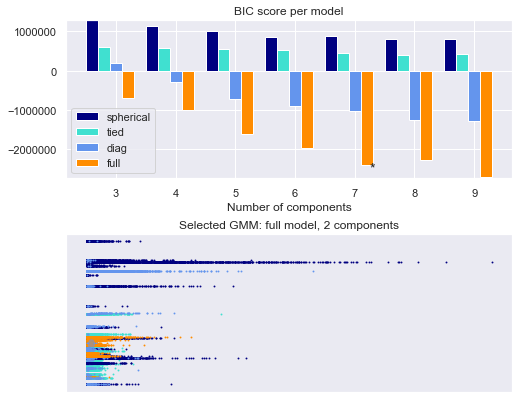

In [115]:
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = umap_results1
X = X_half2

lowest_bic = np.infty
bic = []
n_components_range = range(3, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [116]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=4,covariance_type ='full', random_state=123)



In [117]:
# Fit model
gaussian_clusters1 = gmm_cluster.fit_predict(X_half1)

In [118]:
# Fit model
gaussian_clusters2 = gmm_cluster.fit_predict(X_half2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


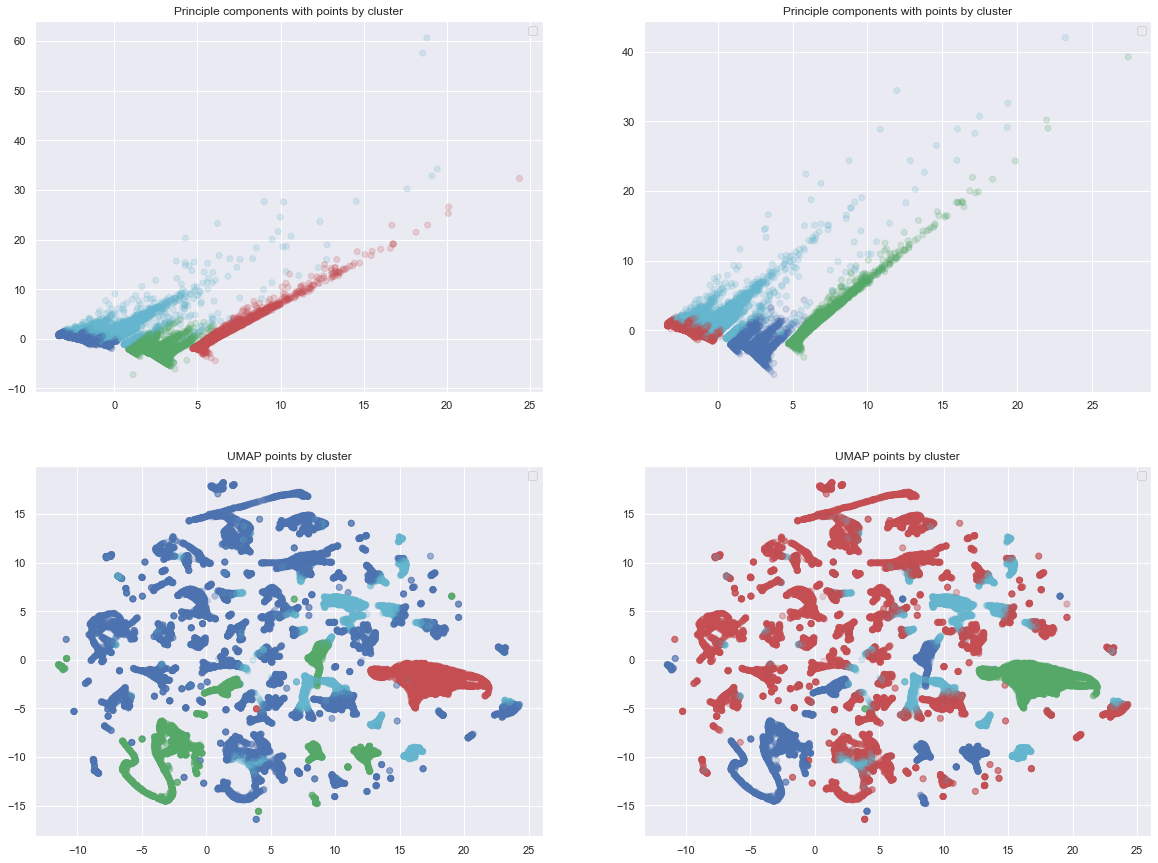

In [119]:
plt.figure(figsize=(20,15))

colours = ['r','b','g','c','m','y','r','b','g','c','m','y']
groups = ['0','1','2','3','4','5']

color_1 = []
color_2 = []
groups = []

colours = ['r','b','g','c','m','y','gray']
for i in range(len(gaussian_clusters1)):
    color_1.append(colours[gaussian_clusters1[i]])

for j in range(len(gaussian_clusters2)):
    color_2.append(colours[gaussian_clusters2[j]])
    
    
    
plt.subplot(2,2,1)
plt.scatter(pca_components1[:, 0],
            pca_components1[:, 1],
            c=color_1,
            #s=20*(y**2),
            alpha = 0.2
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)

plt.subplot(2,2,2)
plt.scatter(pca_components2[:, 0],
            pca_components2[:, 1],
            c=color_2,
            #s=20*(y**2),
            alpha = 0.2
        )
plt.title('Principle components with points by cluster')
plt.legend( [])
plt.legend(groups)


plt.subplot(2,2,3)
plt.scatter(umap_results1[:, 0],
            umap_results1[:, 1],
            c=color_1,
            #s=20*(y**2),
            alpha = 0.2
                )
plt.title('UMAP points by cluster')
plt.legend()


plt.subplot(2,2,4)
plt.scatter(umap_results2[:, 0],
            umap_results2[:, 1],
            c=color_2,
            #s=20*(y**2),
            alpha = 0.2
                )
plt.title('UMAP points by cluster')
plt.legend()

plt.show()

In [120]:


score1 = metrics.silhouette_score(X_half1, gaussian_clusters1, metric='euclidean')

score2 = metrics.silhouette_score(X_half2, gaussian_clusters2, metric='euclidean')

print(score1,score2)
sil_scores.append(('GMM','euclidean',1,score1))
sil_scores.append(('GMM','euclidean',2,score2))

0.3236125248170066 0.31565250930993344


In [121]:

score1 = metrics.silhouette_score(X_half1, gaussian_clusters1, metric='cosine')

score2 = metrics.silhouette_score(X_half2, gaussian_clusters2, metric='cosine')

print(score1,score2)
sil_scores.append(('GMM','cosine',1,score1))
sil_scores.append(('GMM','cosine',2,score2))

0.3867379881905766 0.38022909347674155


In [122]:

score1 = metrics.silhouette_score(X_half1, gaussian_clusters1, metric='manhattan')

score2 = metrics.silhouette_score(X_half2, gaussian_clusters2, metric='manhattan')

print(score1,score2)
sil_scores.append(('GMM','manhattan',1,score1))
sil_scores.append(('GMM','manhattan',2,score2))

0.38507285738588376 0.37807821701917144


## Evaluating Clusters

It appears that K means has the highest silhouette scores (0.49103691347921913, 0.49206848501218103) yet many of the clusters where grouped in similar arangments, and some had similar scores to the K means such as DBSCAN. 
Below the Kmeans clusters are examined first by ploting them on a map of the united states to look at geographic differences in the clusters. 

In [123]:
silhouette_scores = pd.DataFrame(sil_scores)
silhouette_scores.rename(columns={0: 'Clustering_Method', 1: "metric", 2:'splitgroup',3:'score'})



Clustering_Method     metric  splitgroup     score
0             Kmeans  euclidean           1  0.487855
1             Kmeans  euclidean           2  0.486830
2             Kmeans     cosine           1  0.460350
3             Kmeans     cosine           2  0.464433
4             Kmeans  manhattan           1  0.546188
5             Kmeans  manhattan           2  0.544520
6      Agglomerative  euclidean           1  0.273600
7      Agglomerative  euclidean           2  0.270782
8      Agglomerative     cosine           1  0.471005
9      Agglomerative     cosine           2  0.465927
10     Agglomerative  manhattan           1  0.316951
11     Agglomerative  manhattan           2  0.314343
12            DBSCAN  euclidean           1  0.510217
13            DBSCAN  euclidean           2  0.510858
14            DBSCAN     cosine           1  0.243798
15            DBSCAN     cosine           2  0.269842
16            DBSCAN  manhattan           1  0.600622
17            DBSCAN  manhattan           2  0.601014
18           HDBSCAN  euclidean           1  0.251932
19           HDBSCAN  euclidean           2  0.253222
20           HDBSCAN     cosine           1  0.324557
21           HDBSCAN     cosine           2  0.324394
22           HDBSCAN  manhattan           1  0.240755
23           HDBSCAN  manhattan           2  0.241354
24               GMM  euclidean           1  0.323613
25               GMM  euclidean           2  0.315653
26               GMM     cosine           1  0.386738
27               GMM     cosine           2  0.380229
28               GMM  manhattan           1  0.385073
29               GMM  manhattan           2  0.378078

In [124]:
silhouette_scores.head()

0          1  2         3
0  Kmeans  euclidean  1  0.487855
1  Kmeans  euclidean  2  0.486830
2  Kmeans     cosine  1  0.460350
3  Kmeans     cosine  2  0.464433
4  Kmeans  manhattan  1  0.546188

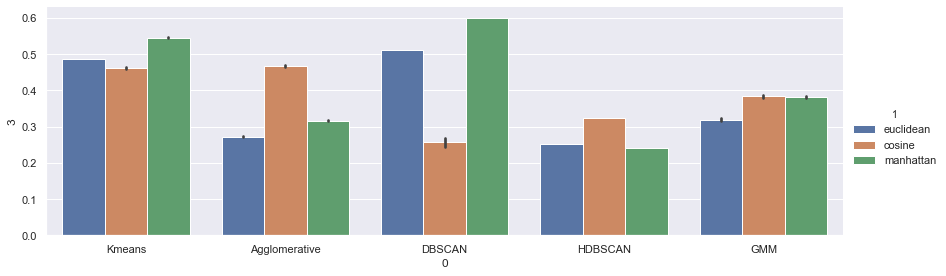

In [125]:

sns.catplot(x=0, y=3,
                hue=1,
                data=silhouette_scores, kind="bar",
                height=4, aspect=3);

#### When Examining the Silhouette Scores for each of the algorithms K means, Agglomerative, and DBSCAN scored the highest however DBDcan only producced 2 clusters and a large number of outliers where K means and agglomerative formed 5 clusters that where consistent when viewed with PCA and UMAP projections. Botht he Aglomerative and K means clusters will be examined below by plotting them on a map. 

In [126]:
Deep_Solar_df = Deep_Solar_df.dropna(subset=['population_density','avg_electricity_retail_rate',
'rebate',
'sales_tax',
'feedin_tariff',
'net_metering',
'incentive_nonresidential_state_level',
'incentive_residential_state_level',
'incentive_count_nonresidential',
'incentive_count_residential',
'total_panel_area_nonresidential',
'total_panel_area_residential',
'solar_system_count_nonresidential',
'solar_system_count_residential',
'tile_count_nonresidential',
'tile_count_residential',
'electricity_price_residential',
'electricity_price_industrial',
'electricity_price_commercial',
'daily_solar_radiation'])
#Deep_Solar_df['dbscan_clusters'] = X['dbscan_clusters']


F = Deep_Solar_df[['avg_electricity_retail_rate',
'rebate',
'sales_tax',
'feedin_tariff',
'net_metering',
'incentive_nonresidential_state_level',
'incentive_residential_state_level',
'incentive_count_nonresidential',
'incentive_count_residential',
'total_panel_area_nonresidential',
'total_panel_area_residential',
'solar_system_count_nonresidential',
'solar_system_count_residential',
'tile_count_nonresidential',
'tile_count_residential',
'electricity_price_residential',
'electricity_price_industrial',
'electricity_price_commercial',
'daily_solar_radiation']]

In [127]:
scaler = StandardScaler()
F_std = scaler.fit_transform(F)

#y_s

In [128]:
# We just want the first two principal components
pca = PCA(n_components=6)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(F_std)

In [129]:
#dbscan_cluster = DBSCAN(eps=3, min_samples=2)
#dbscan_final_cluster = dbscan_cluster.fit_predict(pca_components)
#X['dbscan_clusters'] = dbscan_final_cluster

#Agg_clusters = agg_cluster.fit_predict(pca_components)

kmeans_cluster.fit(F_std)
k_means_clusters = kmeans_cluster.predict(F_std)

In [130]:
gmm_cluster = GaussianMixture(n_components=5,covariance_type ='full', random_state=123)
gaussian_clusters = gmm_cluster.fit_predict(F_std)

In [135]:
dbscan_cluster= dbscan_cluster.fit_predict(pca_components)


In [136]:
Deep_Solar_df.dropna()
Deep_Solar_df['k_means_clusters']= k_means_clusters
Deep_Solar_df['gaussian_clusters']= gaussian_clusters
Deep_Solar_df['dbscan_cluster']= dbscan_cluster

#Deep_Solar_df['Agg_clusters']= Agg_clusters#Deep_Solar_df['dbscan_clusters'] = X['dbscan_clusters']

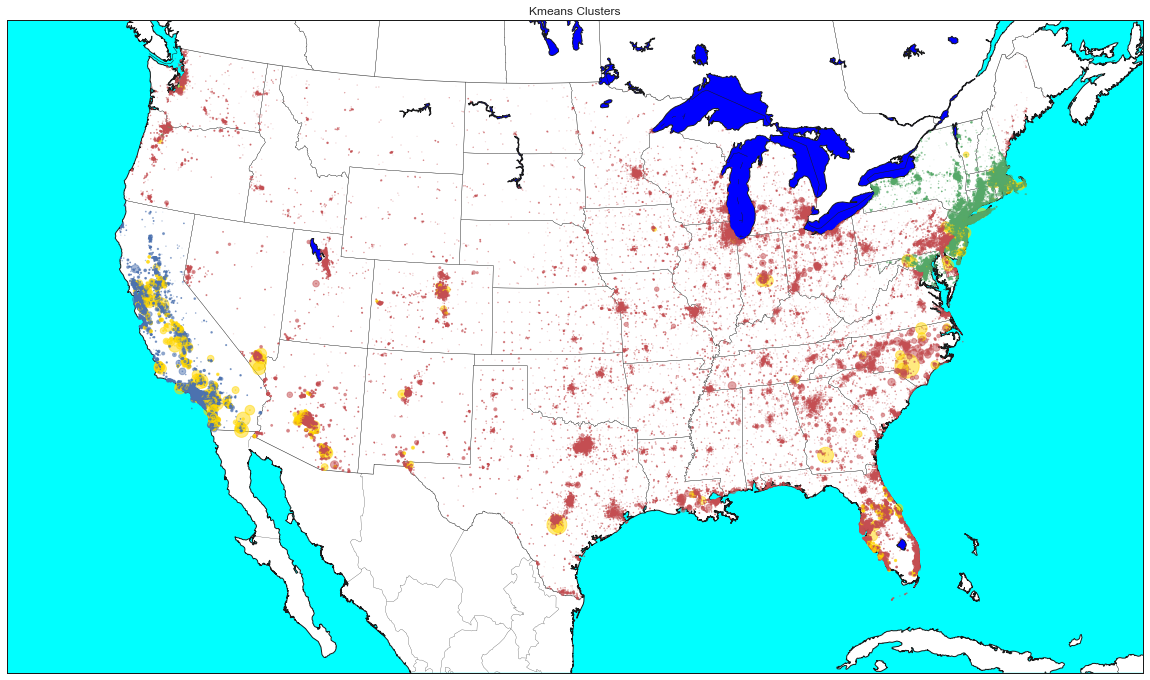

In [139]:
#llcr=18.892007, -123.742010
#urcr=48.572002, -60.451053
#mid=39.156135, -94.742782

#Get county, state, solar pannel area, latitude and longitude data from Deep Solar Dataset
energytype = Deep_Solar_df.loc[:,['k_means_clusters','dbscan_cluster','gaussian_clusters','county', 'state','lat', 'lon','total_panel_area',"total_panel_area_nonresidential","total_panel_area_residential"]]
dbscan_cluster_1
colours = ['r','b','g','gold','c','m','y','k','r','b','g','c','m','y','k','r','b','g','c','m','y','k']
color1 = []
color2 = []

for ind in energytype.index:
    color1.append(colours[energytype['k_means_clusters'][ind]])
    color2.append(colours[energytype['dbscan_cluster'][ind]])

#Determine figure size 
plt.figure(figsize=(24,12))

#create map lcc projection of united states 
map = Basemap(llcrnrlon=-125.,llcrnrlat=20.,urcrnrlon=-60.,urcrnrlat=47.,projection='lcc',lat_1=20.,lat_2=40.,lon_0=-100., resolution='i', area_thresh=1000.)

#fill in colors draw boundries for countries and states 
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='white',lake_color='blue')
map.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
map.drawstates(linewidth=0.25, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
map.drawcoastlines()

#map.drawparallels(np.arange(10,70,20),labels=[1,1,0,0])
#map.drawmeridians(np.arange(-100,0,20),labels=[0,0,0,1])
#plt.title('Fig1. Map with Ploted Solar Installations Scaled to Size of Installation Magenta for Residential and Gold for Non residential installations', fontsize='xx-large')

lons = energytype['lon'].to_numpy()
lats = energytype['lat'].to_numpy()

#x, y = map(lons, lats)
x, y = map(lons, lats)

# plot points to map and scale to pannel area and color for residential and non
plt.scatter(x, y,s=(energytype['total_panel_area_nonresidential']/1000),color=color1, alpha=.5, zorder=9)

plt.scatter(x, y,s=(energytype['total_panel_area_residential']/1000),color=color1 , alpha=.5, zorder=10)
plt.title('Kmeans Clusters')



plt.show()


## Most clusters split along state lines with california appearing as cluster 1. New England states New York new Jersy and Maryland appear as green in   cluster 2, while the rest of the country appears as group 0. The yellow hue represents Group 3, this one is particularly interesting because it is dispered throughout the map. Perhaps examining a pair plot will elucidate what is going on in group2.   

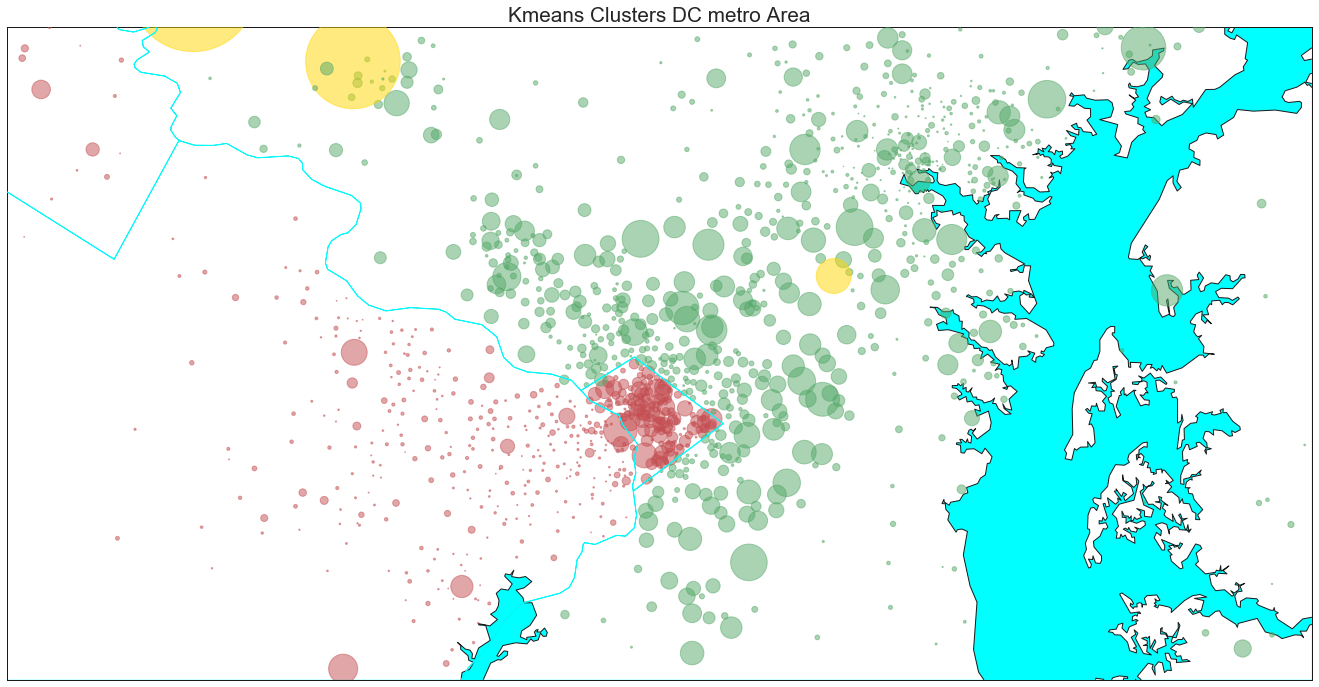

In [141]:
#DC Baltimor 
#llcr=38.540660, -77.879196
#urcr=39.519843, -76.258571
#mid=39.156135, -94.742782

#Get county, state, solar pannel area, latitude and longitude data from Deep Solar Dataset
energytype = Deep_Solar_df.loc[:,['k_means_clusters','dbscan_cluster','county', 'state','lat', 'lon','total_panel_area',"total_panel_area_nonresidential","total_panel_area_residential"]]

colours = ['r','b','g','gold','c','m','y','k','r','b','g','c','m','y','k','r','b','g','c','m','y','k']

color1 = []
color2 = []

for ind in energytype.index:
    color1.append(colours[energytype['k_means_clusters'][ind]])

#Determine figure size 
plt.figure(figsize=(24,12))
#secound plot



#create map lcc projection of united states 
map = Basemap(llcrnrlon=-78,llcrnrlat=38.5,urcrnrlon=-76,urcrnrlat=39.5,projection='cyl',lat_1=38,lat_2=38,lon_0=-77., resolution='h', area_thresh=1000.)

#fill in colors draw boundries for countries and states 
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='white',lake_color='blue')
map.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
map.drawstates(linewidth=0.25, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
map.drawcoastlines()


map.drawstates(linewidth=1, linestyle='solid', color='cyan', antialiased=3, ax=None, zorder=11)

plt.title('''Kmeans Clusters DC metro Area''', fontsize='xx-large') 
lons = energytype['lon'].to_numpy()
lats = energytype['lat'].to_numpy()
#x, y = map(lons, lats)

x, y = map(lons, lats)

s1=(energytype['total_panel_area']/10)

#map.scatter(x, y,s=s1,color='gold', alpha=1, zorder=9)

map.scatter(x, y,s=s1,color=color1, alpha=.5, zorder=10)
#map.scatter(x, y,s=s1,color=color, alpha=.5, zorder=10)




plt.show()

In [142]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(ensemble.RandomForestClassifier(n_estimators = 100))#,max_features=4)

X_select = Deep_Solar_df.select_dtypes(exclude = ['bool','object'])
#X_select = X_select.drop(columns =['K_clusters'])
#X_select = pd.get_dummies(X_select)
X_select = X_select.dropna(axis=1)

Y = Deep_Solar_df['k_means_clusters'].astype('int')
#Y = Y.dropna()


sel.fit(X_select, Y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [143]:
sel.get_support()
#sel.feature_importances_() ,sel.feature_importances_()
selected_feat= X_select.columns[(sel.get_support())].tolist()

#sel.feature_importances_
print(selected_feat)


['fips', 'electricity_price_residential', 'electricity_price_commercial', 'electricity_price_industrial', 'electricity_price_overall', 'electricity_consume_residential', 'electricity_consume_industrial', 'electricity_consume_total', 'lon', 'relative_humidity', 'daily_solar_radiation', 'incentive_count_residential', 'incentive_count_nonresidential', 'incentive_residential_state_level', 'incentive_nonresidential_state_level', 'net_metering', 'property_tax', 'avg_electricity_retail_rate', 'k_means_clusters', 'gaussian_clusters', 'dbscan_cluster']


### Features from random forrests selection 

In [145]:
Deep_Solar_df['log_total_panel_area_nonresidential'] = np.log(Deep_Solar_df.total_panel_area_nonresidential)

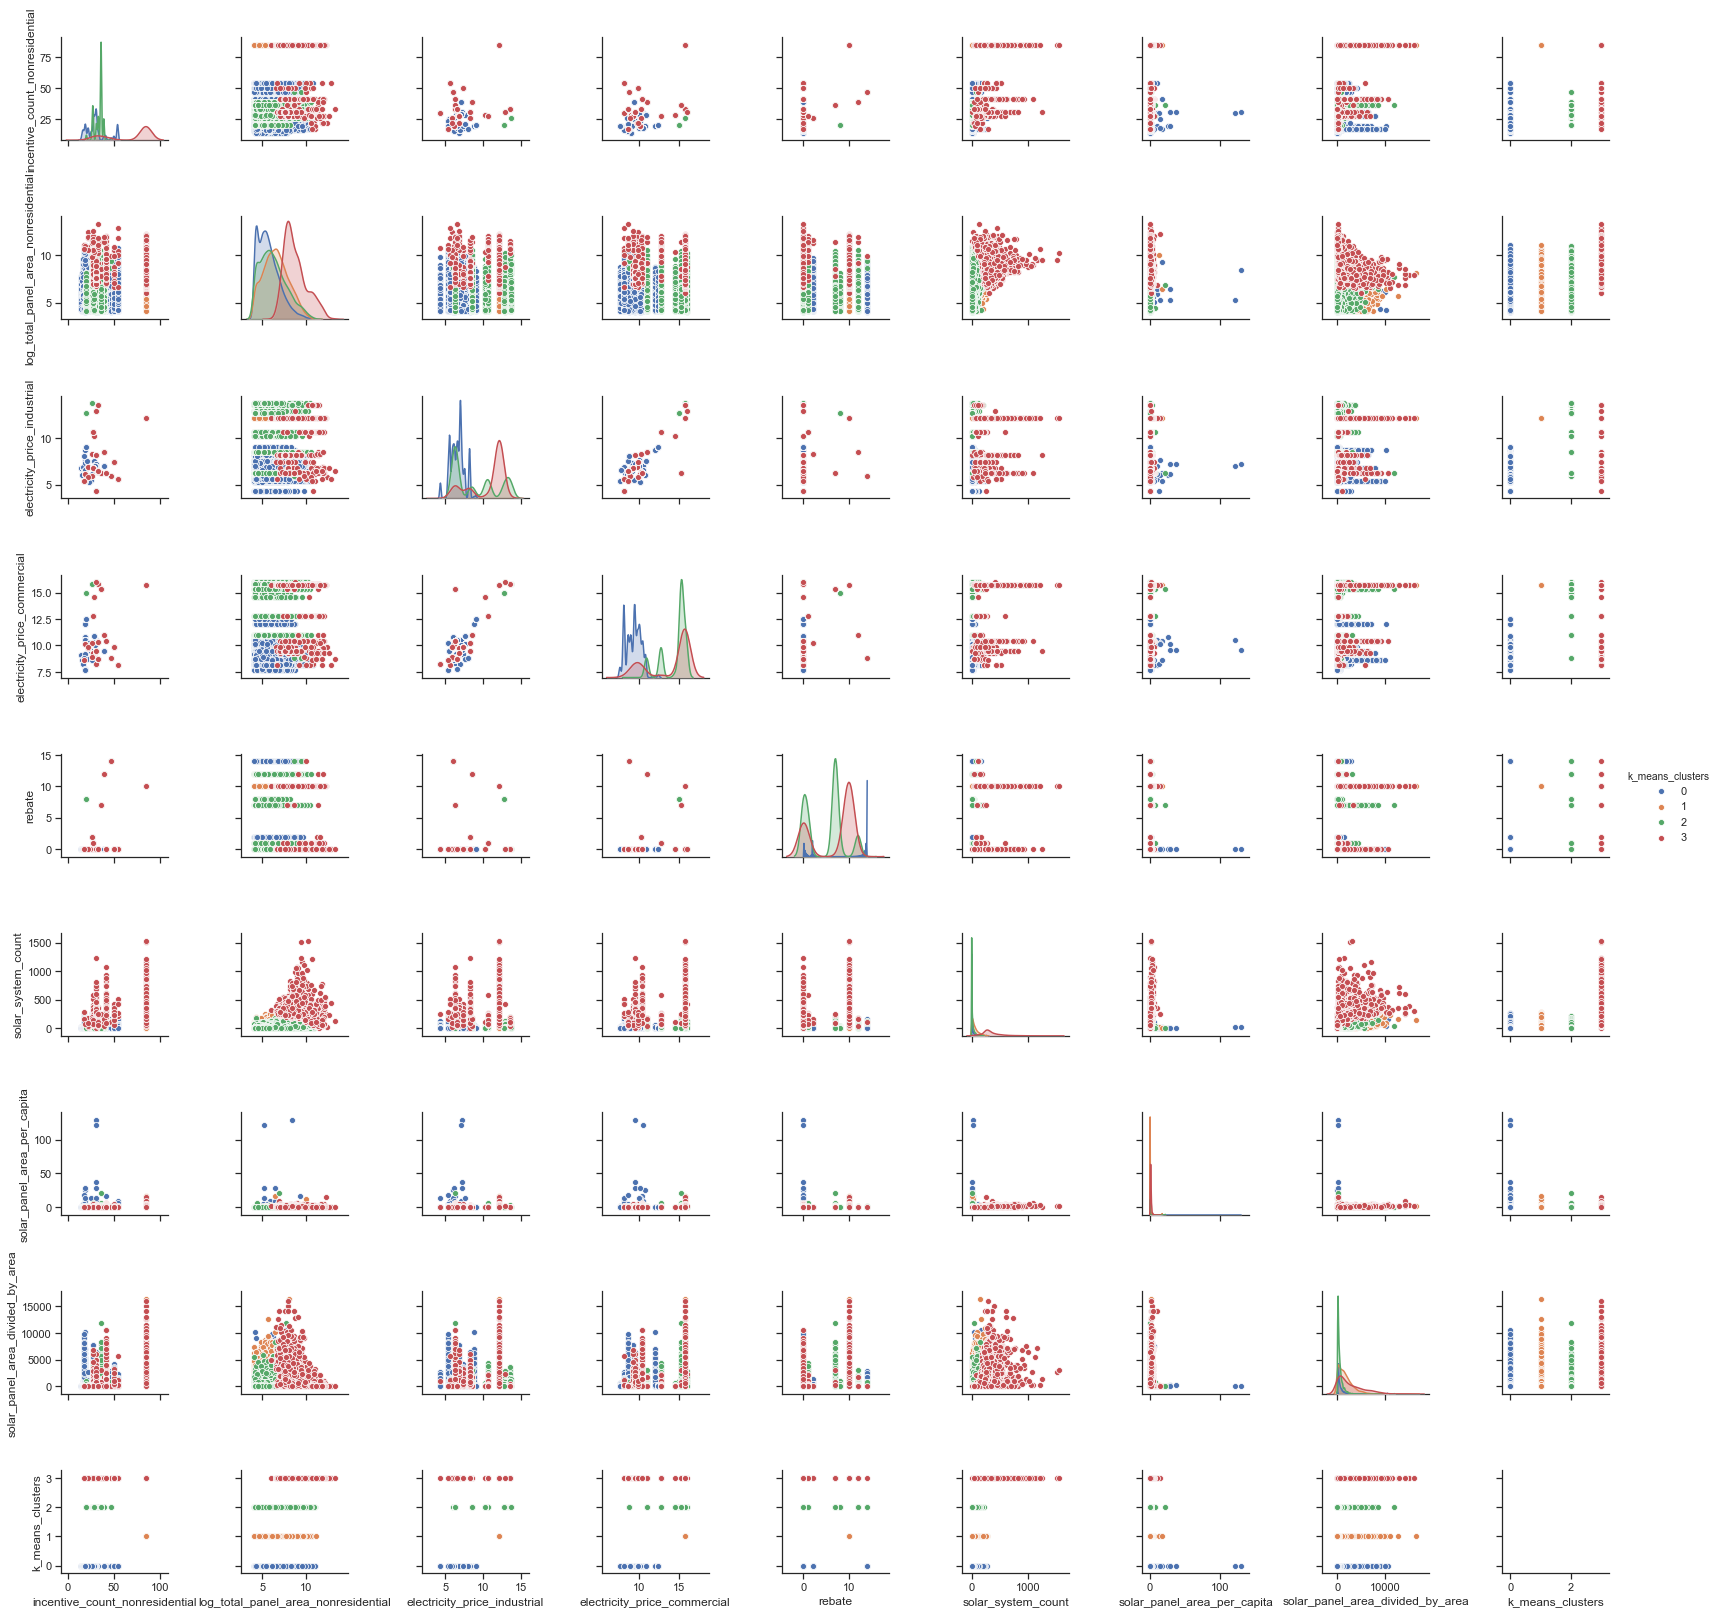

In [147]:
import seaborn as sns
sns.set(style="ticks")

Deep_Solar_df
sns.pairplot(Deep_Solar_df[['incentive_count_nonresidential',
                            'log_total_panel_area_nonresidential',
                            'electricity_price_industrial',
                            'electricity_price_commercial', 
                            'rebate','solar_system_count',
                            'solar_panel_area_per_capita',
                            'solar_panel_area_divided_by_area',
                            'k_means_clusters']], hue="k_means_clusters")




### When examining the plots above the differences in group 3 are much clearer, group 1 pertains to areas with high prices for industrial and comercial electricity, they also apear to have a high number of incentives for non residential solar power generation. These regions also have a high area count of non residential solar. 

### Conclusions 
the clusters apear to be fairly consistant geographically  with the exception of group 3. More work could be done to improve the cluster descriptions. However, these clusters help show which states have effective solar policies, and show areas where non residential solar is quite viable. 


As I have discussed in an earlier notebook if a time component could be added to the data to show when and how solar installations are implemented in specific reagions.  It may provide insight into what governing, marketing and sales strategies are working with customers. 